In [1]:
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import torch
from torch import nn, optim

from ignite.engine import (Events, 
                           create_supervised_trainer,
                           create_supervised_evaluator)
from ignite.metrics import Accuracy

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader

Populating the interactive namespace from numpy and matplotlib


## load data

In [2]:
trans = transforms.Compose([
    transforms.ToTensor()
])

dataset = MNIST("../datasets/mnist/", transform=trans) #, download=True)
dataload = DataLoader(dataset, batch_size=300, shuffle=True)

torch.Size([1, 28, 28])

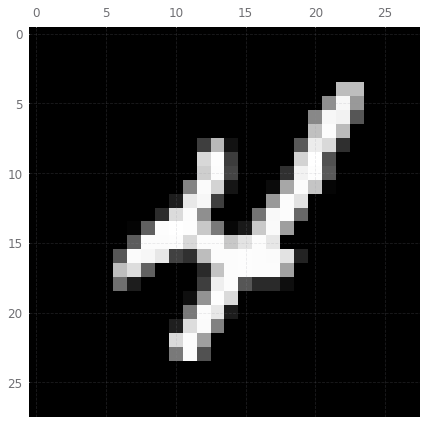

In [3]:
figsize(7, 7)
matshow(dataset[9][0].detach().numpy()[0], cmap=cm.gray)
dataset[9][0].shape

## montando a rede neural

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        
        self.conv0 = nn.Sequential(
            nn.Conv2d(1, 8, 5),
            nn.ReLU()
        )
        
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, output_size)
        self.out = nn.Tanh()
        
    def forward(self, x):
        
        x = nn.functional.max_pool2d(self.conv0(x), kernel_size=5)
#         x = self.conv1(x)

        x = x.view(x.shape[0], -1)
        
        x =  self.l1(x)
        x =  self.l2(x)
        x =  self.l3(x)
        
        return self.out(x)

In [5]:
net = NeuralNet(128, 256, 10)
net

NeuralNet(
  (conv0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
  )
  (l1): Linear(in_features=128, out_features=256, bias=True)
  (l2): Linear(in_features=256, out_features=256, bias=True)
  (l3): Linear(in_features=256, out_features=10, bias=True)
  (out): Tanh()
)

In [6]:
test = next(iter(dataload))
print("previsto: ", net(test[0])[0].argmax())
print("esperado: ", test[1][0])
del test

previsto:  tensor(2)
esperado:  tensor(9)


## treinamento

In [7]:
epochs = 10
learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

trainer = create_supervised_trainer(
    net, optimizer, criterion
)

evaluator = create_supervised_evaluator(
    net, metrics={"accuracy": Accuracy()}
)

In [8]:
@trainer.on(Events.STARTED)
def init_log(trainer):
    trainer._losses = []
    trainer._accuracy = []


@trainer.on(Events.EPOCH_COMPLETED)
def epoch_log(trainer):
    evaluator.run(dataload)
    metrics = evaluator.state.metrics

    trainer._losses.append(
        trainer.state.output
    )
    trainer._accuracy.append(
        metrics["accuracy"]
    )
    
    if trainer.state.epoch % 1 == 0:
        print(f"epoch: {trainer.state.epoch:<2} | " + \
              f"accuracy: {metrics['accuracy']:.2f} | " + \
              f"loss: {trainer.state.output:.2f}")
              
@trainer.on(Events.COMPLETED)
def save_onnx(trainer):
    print("-"*80)
    filename = "netconv.onnx"
    torch.onnx.export(net, torch.randn(1, 1, 28, 28),
                      filename,
                      input_names = [ "input_1" ] + [ "learned_%d" % i for i in range(8) ],
                      output_names = ["output"],
                      export_params=True, verbose=True)
    print("-"*80)
    print(f"{filename} save!!!")

In [9]:
final_state = trainer.run(dataload, max_epochs=5)

epoch: 1  | accuracy: 0.78 | loss: 1.44
epoch: 2  | accuracy: 0.87 | loss: 1.17
epoch: 3  | accuracy: 0.90 | loss: 1.07
epoch: 4  | accuracy: 0.92 | loss: 1.02
epoch: 5  | accuracy: 0.92 | loss: 1.01
--------------------------------------------------------------------------------
graph(%input_1 : Float(1, 1, 28, 28)
      %learned_0 : Float(8, 1, 5, 5)
      %learned_1 : Float(8)
      %learned_2 : Float(256, 128)
      %learned_3 : Float(256)
      %learned_4 : Float(256, 256)
      %learned_5 : Float(256)
      %learned_6 : Float(10, 256)
      %learned_7 : Float(10)) {
  %9 : Float(1, 8, 24, 24) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[0, 0, 0, 0], strides=[1, 1]](%input_1, %learned_0, %learned_1), scope: NeuralNet/Sequential[conv0]/Conv2d[0]
  %10 : Float(1, 8, 24, 24) = onnx::Relu(%9), scope: NeuralNet/Sequential[conv0]/ReLU[1]
  %11 : Float(1, 8, 4, 4) = onnx::MaxPool[kernel_shape=[5, 5], pads=[0, 0, 0, 0], strides=[5, 5]](%10), scope: NeuralNet
  %12 : 

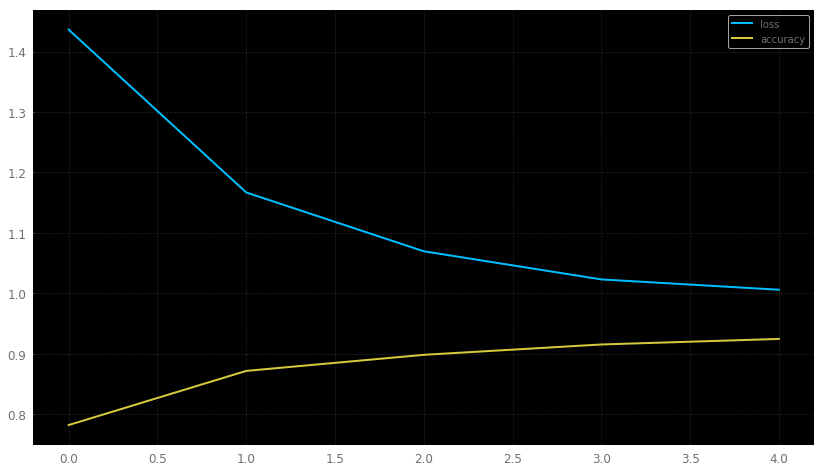

In [10]:
fig, ax = subplots(figsize=(14, 8))
ax.plot(trainer._losses, label="loss")
ax.plot(trainer._accuracy, label="accuracy")
ax.legend()

## coisas para comparar com a importação

In [12]:
torch.__version__

'1.0.0'

torch.Size([1, 28, 28])

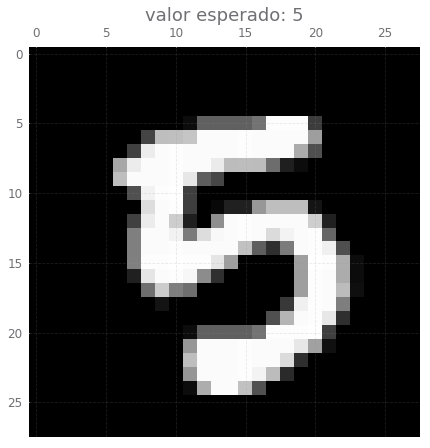

In [17]:
n = 554
matshow(dataset[n][0].reshape(28, 28), cmap=cm.gray)
plt.title(f"valor esperado: {dataset[n][1]}")
dataset[n][0].shape

In [18]:
%time
out = net(dataset[n][0].view(1, 1, 28, 28))

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 15.3 µs


In [19]:
print(out)
print(out.argmax().item())

tensor([[-0.9988, -1.0000, -1.0000, -0.9982, -0.9999,  0.0411, -0.9995, -0.9998,
         -0.9850, -0.9904]], grad_fn=<TanhBackward>)
5


In [23]:
%%timeit
m = np.random.randint(6000)
net(dataset[m][0].view(1, 1, 28, 28));

1.67 ms ± 83.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
